# Credit card approval prediction

## Introduction ===========

**Objective**: To predict whether to approve a credit card to customer



## Import libraries ===========

In [ ]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTENC, SMOTEN
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Read data ===========

In [ ]:
df= pd.read_csv("../input/credit-card-approval-prediction/application_record.csv", encoding = 'utf-8')
df_credit = pd.read_csv("../input/credit-card-approval-prediction/credit_record.csv", encoding = 'utf-8')

### Usable data

We have 2 tables, the first one contains information of each customer, and the second record the payment behavior.

In [ ]:
print('For the first table, number of unique customer ID',df['ID'].nunique())
print('For the second table, number of unique customer ID',df_credit['ID'].nunique())
print('Number of unique customer ID that appearing in both tables:',df[df['ID'].isin(df_credit['ID'])]['ID'].nunique())

For the first table, number of unique customer ID 438510
For the second table, number of unique customer ID 45985
Number of unique customer ID that appearing in both tables: 36457


Only **36457** curtomers are on both table. Hence the maximum usable data to train the model is 36457 samples.

In [ ]:
# Filter only usable sample
df = df[df['ID'].isin(df_credit['ID'])]
df_credit = df_credit[df_credit['ID'].isin(df['ID'])]

## Label good/bad customers ===========
As the data only provide the credit record (status), but not the decision on whether we should approve a credit card, we first set up the criteria.



We consider customer who make a payment later than 90 days as bad customer.

We also removed customer with only X status, as those customer never used the credit card and are non-benificial data.

We also removed the indeterminates, which is defined as pasting due less than 90 days (but not on time), as they are not strictly defined as good or bad customer.

We used 12 months window as consideration period, we also remove customer with recording period less than 12 months.

In [ ]:
# make label
def label_bad(df):
    if (df["STATUS"]=='3') | (df["STATUS"]=='4') | (df["STATUS"]=='5'): # bad
        return 2
    elif (df["STATUS"]=='X'): # no record
        return -1
    elif (df["STATUS"]=='0') | (df["STATUS"]=='1') | (df["STATUS"]=='2'): # indeterminates
        return 1
    else:
        return 0


In [ ]:
df_credit["MONTHS_BALANCE"] = -df_credit["MONTHS_BALANCE"]
df_credit = df_credit[df_credit["MONTHS_BALANCE"]<=12]
df_credit["Bad_Customer"] = df_credit.apply(label_bad, axis=1)

In [ ]:
df_credit_labeled = df_credit[['ID','Bad_Customer',"MONTHS_BALANCE"]].groupby('ID',as_index=False).max()

In [ ]:
# remove customer with only X status (no usage data) (labeled as -1)
df_credit_labeled = df_credit_labeled[df_credit_labeled['Bad_Customer']!=-1]
# remove indeterminates customer (labeled as 1)
df_credit_labeled = df_credit_labeled[df_credit_labeled['Bad_Customer']!=1]
# remove customer with period of record less than 12 month
df_credit_labeled = df_credit_labeled[df_credit_labeled['MONTHS_BALANCE']==12]
# Tag Bad_customer as 1 instead (former = 2)
df_credit_labeled['Bad_Customer'] = (df_credit_labeled['Bad_Customer']/2).apply(np.int32)
df_credit_labeled =  df_credit_labeled.drop('MONTHS_BALANCE', axis=1)

In [ ]:
# merge
df_labeled = df.merge(df_credit_labeled,on='ID',how='inner')

## Observe and clean data ===========

### Check customer information table

In [ ]:
df_labeled.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Bad_Customer
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
1,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
2,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
3,5008826,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,-10669,-1103,1,0,0,0,Accountants,2.0,0
4,5008830,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,-10031,-1469,1,0,1,0,Laborers,2.0,0
5,5008832,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,-10031,-1469,1,0,1,0,Laborers,2.0,0
6,5008834,F,N,Y,1,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-10968,-1620,1,0,0,0,NaN,2.0,0
7,5008836,M,Y,Y,3,270000.0,Working,Secondary / secondary special,Married,House / apartment,-12689,-1163,1,0,0,0,Laborers,5.0,0
8,5008837,M,Y,Y,3,270000.0,Working,Secondary / secondary special,Married,House / apartment,-12689,-1163,1,0,0,0,Laborers,5.0,0
9,5008840,M,N,Y,1,405000.0,Commercial associate,Higher education,Married,House / apartment,-11842,-2016,1,0,0,0,Managers,3.0,0


There are many information that duplicated, but have different ID. These may come from multiple credit cards per user.

In [ ]:
df_labeled = df_labeled.drop('ID',axis=1)

In [ ]:
# Check whether multiple cards holder are labeled with bad/good or mixing
print('Amount of duplicated data with bad customer labeling: ', df_labeled.duplicated().sum())
print('Amount of duplicated data without bad customer labeling: ', df_labeled.drop('Bad_Customer',axis=1).duplicated().sum())

Amount of duplicated data with bad customer labeling:  5271
Amount of duplicated data without bad customer labeling:  5313


Since the amounts above are not equal, there are customer who are labeled as good and bad customer on different ID. We consider these customers as bad customers (have at least 1 labeled as bad customer).

In [ ]:
# Flag duplicate information that come from the same customer
df_labeled['ID_same_customer'] = df_labeled.groupby(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'], dropna=False).ngroup()

In [ ]:
# Combine information to be just 1 for each customer. Bad_customer tag is 1 if one or more ID is tagged as bad_customer
df_labeled = df_labeled.groupby(['ID_same_customer','CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],as_index=False,dropna=False).max()


In [ ]:
# Recheck for the duplicaite information
df_labeled.drop('ID_same_customer',axis=1).duplicated().sum()

0

### Check for missing data

In [ ]:
df_labeled.isna().sum()/df.shape[0]*100

ID_same_customer       0.000000
CODE_GENDER            0.000000
FLAG_OWN_CAR           0.000000
FLAG_OWN_REALTY        0.000000
CNT_CHILDREN           0.000000
AMT_INCOME_TOTAL       0.000000
NAME_INCOME_TYPE       0.000000
NAME_EDUCATION_TYPE    0.000000
NAME_FAMILY_STATUS     0.000000
NAME_HOUSING_TYPE      0.000000
DAYS_BIRTH             0.000000
DAYS_EMPLOYED          0.000000
FLAG_MOBIL             0.000000
FLAG_WORK_PHONE        0.000000
FLAG_PHONE             0.000000
FLAG_EMAIL             0.000000
OCCUPATION_TYPE        4.226897
CNT_FAM_MEMBERS        0.000000
Bad_Customer           0.000000
dtype: float64

About 4.2 % of occupation information is missing, which is a significant amount.

Text(0.5, 1.0, "Income type of customer that don't have occupation data")

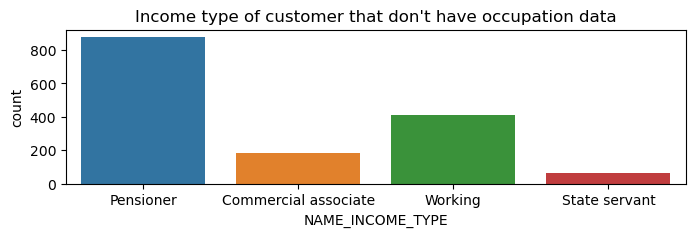

In [ ]:
plt.figure(figsize=(8,2))
sns.countplot(x= df_labeled[df_labeled["OCCUPATION_TYPE"].isna()]["NAME_INCOME_TYPE"])
plt.title("Income type of customer that don't have occupation data")

From the plot, most of the missing occupation data are pensioner which is make sense. We labeled occupation types of Pensioner as "Pensioner".

In [ ]:
# label pensioner occupation type
df_labeled.loc[df_labeled["NAME_INCOME_TYPE"]=="Pensioner","OCCUPATION_TYPE"] = "Pensioner"

In [ ]:
# Check missing data after assigning pensioner
df_labeled.isna().sum()/df.shape[0]*100

ID_same_customer       0.000000
CODE_GENDER            0.000000
FLAG_OWN_CAR           0.000000
FLAG_OWN_REALTY        0.000000
CNT_CHILDREN           0.000000
AMT_INCOME_TOTAL       0.000000
NAME_INCOME_TYPE       0.000000
NAME_EDUCATION_TYPE    0.000000
NAME_FAMILY_STATUS     0.000000
NAME_HOUSING_TYPE      0.000000
DAYS_BIRTH             0.000000
DAYS_EMPLOYED          0.000000
FLAG_MOBIL             0.000000
FLAG_WORK_PHONE        0.000000
FLAG_PHONE             0.000000
FLAG_EMAIL             0.000000
OCCUPATION_TYPE        1.818581
CNT_FAM_MEMBERS        0.000000
Bad_Customer           0.000000
dtype: float64

About 1.8 % of occupation information is missing.

We decided to remove these data.

In [ ]:
# drop null occupation rows
df_labeled = df_labeled.dropna(axis=0)

### Check for mis-spelling of categorical columns

In [ ]:
df_labeled["CODE_GENDER"].unique()

array(['F', 'M'], dtype=object)

In [ ]:
df_labeled["FLAG_OWN_CAR"].unique()

array(['N', 'Y'], dtype=object)

In [ ]:
df_labeled["FLAG_OWN_REALTY"].unique()

array(['N', 'Y'], dtype=object)

In [ ]:
df_labeled["NAME_INCOME_TYPE"].unique()

array(['Working', 'Pensioner', 'State servant', 'Commercial associate',
       'Student'], dtype=object)

In [ ]:
df_labeled["NAME_FAMILY_STATUS"].unique()

array(['Civil marriage', 'Married', 'Single / not married', 'Widow',
       'Separated'], dtype=object)

In [ ]:
df_labeled["NAME_HOUSING_TYPE"].unique()

array(['House / apartment', 'Office apartment', 'With parents',
       'Municipal apartment', 'Co-op apartment', 'Rented apartment'],
      dtype=object)

In [ ]:
df_labeled["OCCUPATION_TYPE"].unique()

array(['Managers', 'Pensioner', 'Core staff', 'Accountants',
       'Sales staff', 'Cleaning staff', 'Medicine staff', 'Laborers',
       'Security staff', 'High skill tech staff', 'Cooking staff',
       'Private service staff', 'Waiters/barmen staff', 'Secretaries',
       'HR staff', 'Low-skill Laborers', 'Drivers', 'IT staff',
       'Realty agents'], dtype=object)

All of the categorical data look good. There is no mis-spelling and repeated type.

### Remove sensitive data

Here we remove gender out of considering data as it is a sensitive judement.

In [ ]:
# drop gender
df_labeled = df_labeled.drop("CODE_GENDER", axis=1)

In [ ]:
df_labeled.head()

,ID_same_customer,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Bad_Customer
0,0,N,N,0,27000.0,Working,Higher education,Civil marriage,House / apartment,-14869,-5067,1,1,0,0,Managers,2.0,0
1,1,N,N,0,33300.0,Pensioner,Secondary / secondary special,Married,Office apartment,-19605,365243,1,0,0,0,Pensioner,2.0,0
2,2,N,N,0,36000.0,Working,Secondary / secondary special,Married,With parents,-14500,-459,1,1,0,0,Core staff,2.0,0
3,3,N,N,0,36900.0,Pensioner,Higher education,Married,House / apartment,-22581,365243,1,0,0,0,Pensioner,2.0,0
4,4,N,N,0,40500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-21091,365243,1,0,0,0,Pensioner,1.0,0


</br>
</br>




## Exploratory data analysis (EDA) and Features engineering  ===========

In [ ]:
# define WOE (weight of evidence) fuction for later uses
def WOE_cal(df,col_name):
    WOE = pd.DataFrame()
    total_bad = df["Bad_Customer"].sum()
    total_good = df.shape[0]-total_bad
    WOE["Dist_bad"]  = (df_labeled.groupby(col_name)["Bad_Customer"].sum())/total_bad
    WOE["Dist_good"] = (df_labeled.groupby(col_name)["Bad_Customer"].count()-df_labeled.groupby(col_name)["Bad_Customer"].sum())/total_good
    WOE["WOE"] = (np.log((WOE["Dist_good"]/WOE["Dist_bad"])))
    IV = (WOE["WOE"]*(WOE["Dist_good"]-WOE["Dist_bad"])).sum() # information value
    return [WOE, IV]

### Set DAYS_BIRTH, DAYS_EMPLOTED to a more appropriate format

Both parameter are recorded as amount of date back in time. For example, DAYS_BIRTH equaling -750000 means 20 years old.

In [ ]:
# Adjust DAYS_BIRTH to AGE in year
df_labeled["AGE"] = ((-df_labeled["DAYS_BIRTH"])/365).apply(int)
df_labeled = df_labeled.drop(["DAYS_BIRTH"],axis=1)

In [ ]:
# Adjust DAYS_EMPLOYED to YEAR_EMPLOYED in year
df_labeled["YEAR_EMPLOYED"] = np.ceil(-(df_labeled["DAYS_EMPLOYED"]/365))
df_labeled = df_labeled.drop(["DAYS_EMPLOYED"],axis=1)

In [ ]:
df_labeled = df_labeled.reset_index(drop=True)
df_labeled = df_labeled.drop(["ID_same_customer"],axis=1)

In [ ]:
df_labeled.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Bad_Customer,AGE,YEAR_EMPLOYED
0,N,N,0,27000.0,Working,Higher education,Civil marriage,House / apartment,1,1,0,0,Managers,2.0,0,40,14.0
1,N,N,0,33300.0,Pensioner,Secondary / secondary special,Married,Office apartment,1,0,0,0,Pensioner,2.0,0,53,-1000.0
2,N,N,0,36000.0,Working,Secondary / secondary special,Married,With parents,1,1,0,0,Core staff,2.0,0,39,2.0
3,N,N,0,36900.0,Pensioner,Higher education,Married,House / apartment,1,0,0,0,Pensioner,2.0,0,61,-1000.0
4,N,N,0,40500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,1,0,0,0,Pensioner,1.0,0,57,-1000.0


</br>




###  FLAG_MOBIL, FLAG_WORK_PHONE, FLAG_PHONE, and FLAG_EMAIL

FLAG_MOBIL (Is there a mobile phone) is 1 for all row, which is not a beneficial data.


In [ ]:
# Show that FLAG_MOBIL only contain value 1
df_labeled["FLAG_MOBIL"].value_counts()

1    4284
Name: FLAG_MOBIL, dtype: int64

In [ ]:
# Drop FLAG_MOBIL
df_labeled = df_labeled.drop('FLAG_MOBIL',axis=1)

</br>

Check WOE(weight of evidence), and IV (information value) of the rest.

#### > FLAG_WORK_PHONE

In [ ]:
[WOE, IV] = WOE_cal(df_labeled,"FLAG_WORK_PHONE")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.005711083265458758


,Dist_bad,Dist_good,WOE
FLAG_WORK_PHONE,,,
1,0.247312,0.215462,-0.137867
0,0.752688,0.784538,0.041444


#### > FLAG_PHONE

In [ ]:
[WOE, IV] = WOE_cal(df_labeled,"FLAG_PHONE")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.020088810078150013


,Dist_bad,Dist_good,WOE
FLAG_PHONE,,,
1,0.354839,0.288714,-0.206227
0,0.645161,0.711286,0.097574


#### > FLAG_EMAIL

In [ ]:
[WOE, IV] = WOE_cal(df_labeled,"FLAG_EMAIL")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.015541933951965283


,Dist_bad,Dist_good,WOE
FLAG_EMAIL,,,
1,0.11828,0.081126,-0.377045
0,0.88172,0.918874,0.041274


The IV lower than 0.02 is normally considered as useless, as FLAG_WORK_PHONE, and FLAG_EMAIL have IV much lower than this criteria, we decided to drop it.

In [ ]:
# Drop old flag
df_labeled = df_labeled.drop(["FLAG_WORK_PHONE","FLAG_EMAIL","FLAG_PHONE"],axis=1)

</br>






### FLAG_OWN_CAR

In [ ]:
# Percentage of sample of each income type
df_labeled["FLAG_OWN_CAR"].value_counts(normalize=True)*100

N    62.138189
Y    37.861811
Name: FLAG_OWN_CAR, dtype: float64

In [ ]:
[WOE, IV] = WOE_cal(df_labeled,"FLAG_OWN_CAR")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.0025440155398926954


,Dist_bad,Dist_good,WOE
FLAG_OWN_CAR,,,
N,0.645161,0.620854,-0.038404
Y,0.354839,0.379146,0.066257


In [ ]:
# Drop FLAG_OWN_CAR as IV is very low
df_labeled = df_labeled.drop(["FLAG_OWN_CAR"],axis=1)

</br>





### FLAG_OWN_REALTY

In [ ]:
# Percentage of sample of each income type
df_labeled["FLAG_OWN_REALTY"].value_counts(normalize=True)*100

Y    66.643324
N    33.356676
Name: FLAG_OWN_REALTY, dtype: float64

In [ ]:
[WOE, IV] = WOE_cal(df_labeled,"FLAG_OWN_REALTY")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.013018083799736657


,Dist_bad,Dist_good,WOE
FLAG_OWN_REALTY,,,
N,0.387097,0.332379,-0.152399
Y,0.612903,0.667621,0.085514


In [ ]:
# Drop FLAG_OWN_CAR as IV is very low
df_labeled = df_labeled.drop(["FLAG_OWN_REALTY"],axis=1)

</br>





### NAME_INCOME_TYPE (Type of income)

In [ ]:
# Percentage of sample of each income type
df_labeled["NAME_INCOME_TYPE"].value_counts(normalize=True)*100

Working                 48.646125
Commercial associate    22.992530
Pensioner               20.728291
State servant            7.609711
Student                  0.023343
Name: NAME_INCOME_TYPE, dtype: float64

Student frequency is too small, and we cannot re-categorize it to other group. We decided to drop it.

In [ ]:
df_labeled = df_labeled[df_labeled["NAME_INCOME_TYPE"]!="Student"]
df_labeled["NAME_INCOME_TYPE"].value_counts(normalize=True)*100

Working                 48.657483
Commercial associate    22.997899
Pensioner               20.733131
State servant            7.611487
Name: NAME_INCOME_TYPE, dtype: float64

In [ ]:
[WOE, IV] = WOE_cal(df_labeled,"NAME_INCOME_TYPE")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.08690258519566955


,Dist_bad,Dist_good,WOE
NAME_INCOME_TYPE,,,
Commercial associate,0.279570,0.228878,-0.200062
Pensioner,0.236559,0.206683,-0.135014
Working,0.462366,0.487112,0.052139
State servant,0.021505,0.077327,1.279740


</br>





### NAME_EDUCATION_TYPE (Type of education)

In [ ]:
# Percentage of sample of each education type
df_labeled["NAME_EDUCATION_TYPE"].value_counts(normalize=True)*100

Secondary / secondary special    70.044361
Higher education                 25.449451
Incomplete higher                 3.105300
Lower secondary                   1.354191
Academic degree                   0.046696
Name: NAME_EDUCATION_TYPE, dtype: float64

We decided to combine incomplete higher, and academic degree into Higher education group, and Lower secondary into Secondary / secondary special. For the later case, we also renamed it to be "Secondary/Lower".

In [ ]:
df_labeled["NAME_EDUCATION_TYPE"] = df_labeled["NAME_EDUCATION_TYPE"].replace({"Academic degree":"Higher education","Lower secondary":"Secondary/Lower","Secondary / secondary special":"Secondary/Lower"})
df_labeled["NAME_EDUCATION_TYPE"].value_counts(normalize=True)*100

Secondary/Lower      71.398552
Higher education     25.496148
Incomplete higher     3.105300
Name: NAME_EDUCATION_TYPE, dtype: float64

In [ ]:
[WOE, IV] = WOE_cal(df_labeled,"NAME_EDUCATION_TYPE")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.005586494848586235


,Dist_bad,Dist_good,WOE
NAME_EDUCATION_TYPE,,,
Incomplete higher,0.043011,0.030788,-0.334338
Secondary/Lower,0.720430,0.713842,-0.009186
Higher education,0.236559,0.255370,0.076515


The majority is in the Secondary/Lower at 71% and another majority group is Higher education at 25%. The Distribution of good and bad customer is both group are quite the same, which indicating low predicting power. This also confirmed by low IV score at 0.005. We decided to drop this feature.

In [ ]:
df_labeled = df_labeled.drop("NAME_EDUCATION_TYPE", axis=1)

</br>





### NAME_FAMILY_STATUS

In [ ]:
df_labeled["NAME_FAMILY_STATUS"].value_counts(normalize=True)*100

Married                 68.876955
Single / not married    12.748074
Civil marriage           8.311931
Separated                5.603549
Widow                    4.459491
Name: NAME_FAMILY_STATUS, dtype: float64

In [ ]:
[WOE, IV] = WOE_cal(df_labeled,"NAME_FAMILY_STATUS")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.07927244771187314


,Dist_bad,Dist_good,WOE
NAME_FAMILY_STATUS,,,
Widow,0.064516,0.044153,-0.379260
Single / not married,0.172043,0.126492,-0.307568
Separated,0.075269,0.055609,-0.302728
Married,0.655914,0.689499,0.049935
Civil marriage,0.032258,0.084248,0.959999


As WOE of Widow/not married are close together, we combined these groups.

In [ ]:
df_labeled["NAME_FAMILY_STATUS"] = df_labeled["NAME_FAMILY_STATUS"].replace({"Widow":"Separated/Widow","Separated":"Separated/Widow"})
df_labeled["NAME_FAMILY_STATUS"].value_counts(normalize=True)*100

Married                 68.876955
Single / not married    12.748074
Separated/Widow         10.063040
Civil marriage           8.311931
Name: NAME_FAMILY_STATUS, dtype: float64

In [ ]:
[WOE, IV] = WOE_cal(df_labeled,"NAME_FAMILY_STATUS")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.07909866420747196


,Dist_bad,Dist_good,WOE
NAME_FAMILY_STATUS,,,
Separated/Widow,0.139785,0.099761,-0.337324
Single / not married,0.172043,0.126492,-0.307568
Married,0.655914,0.689499,0.049935
Civil marriage,0.032258,0.084248,0.959999


</br>





### NAME_HOUSING_TYPE

In [ ]:
df_labeled["NAME_HOUSING_TYPE"].value_counts(normalize=True)*100

House / apartment      89.633435
With parents            4.342750
Municipal apartment     3.478870
Rented apartment        1.260799
Office apartment        0.863880
Co-op apartment         0.420266
Name: NAME_HOUSING_TYPE, dtype: float64

In [ ]:
df_labeled["NAME_HOUSING_TYPE"] = df_labeled["NAME_HOUSING_TYPE"].replace({"Co-op apartment":"House / apartment","Office apartment":"House / apartment"})
df_labeled["NAME_HOUSING_TYPE"].value_counts(normalize=True)*100

House / apartment      90.917581
With parents            4.342750
Municipal apartment     3.478870
Rented apartment        1.260799
Name: NAME_HOUSING_TYPE, dtype: float64

In [ ]:
# Calculate WOE
[WOE, IV] = WOE_cal(df_labeled,"NAME_HOUSING_TYPE")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.004243038632810376


,Dist_bad,Dist_good,WOE
NAME_HOUSING_TYPE,,,
House / apartment,0.924731,0.908831,-0.017344
Municipal apartment,0.032258,0.034845,0.077138
Rented apartment,0.010753,0.012649,0.162435
With parents,0.032258,0.043675,0.303017


In [ ]:
# Drop NAME_HOUSING_TYPE as IV is very low
df_labeled = df_labeled.drop("NAME_HOUSING_TYPE", axis=1)

</br>





### OCCUPATION_TYPE

In [ ]:
df_labeled["OCCUPATION_TYPE"].value_counts(normalize=True)*100

Pensioner                20.733131
Laborers                 20.429605
Sales staff              10.506654
Core staff               10.389914
Managers                  9.502685
Drivers                   7.658184
High skill tech staff     4.482839
Accountants               3.689003
Medicine staff            3.572262
Security staff            2.077983
Cooking staff             1.937894
Cleaning staff            1.751109
Private service staff     0.887229
Low-skill Laborers        0.723792
Secretaries               0.583703
Waiters/barmen staff      0.490311
HR staff                  0.256829
IT staff                  0.186785
Realty agents             0.140089
Name: OCCUPATION_TYPE, dtype: float64

In [ ]:
df_labeled = df_labeled[~df_labeled["OCCUPATION_TYPE"].isin(["Private service staff","Low-skill Laborers","Secretaries","Waiters/barmen staff","HR staff","IT staff","Realty agents"])]

In [ ]:
# Calculate WOE
[WOE, IV] = WOE_cal(df_labeled,"OCCUPATION_TYPE")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.08176213036065198


,Dist_bad,Dist_good,WOE
OCCUPATION_TYPE,,,
Security staff,0.044944,0.020967,-0.762466
High skill tech staff,0.067416,0.045881,-0.384836
Cleaning staff,0.022472,0.018007,-0.221511
Medicine staff,0.044944,0.036754,-0.201171
Pensioner,0.247191,0.213616,-0.145981
Cooking staff,0.022472,0.019980,-0.117521
Managers,0.101124,0.098175,-0.029596
Laborers,0.202247,0.211396,0.044243
Core staff,0.101124,0.107548,0.061595


In [ ]:
# GROUP BY WOE SCORE
df_labeled['OCCUPATION_TYPE'] = df_labeled['OCCUPATION_TYPE'].replace({"Security staff":"G1"})
df_labeled['OCCUPATION_TYPE'] = df_labeled['OCCUPATION_TYPE'].replace({"High skill tech staff":"G2"})
df_labeled['OCCUPATION_TYPE'] = df_labeled['OCCUPATION_TYPE'].replace({"Cleaning staff":"G3","Medicine staff":"G3"})
df_labeled['OCCUPATION_TYPE'] = df_labeled['OCCUPATION_TYPE'].replace({"Pensioner":"G4","Cooking staff":"G4"})
df_labeled['OCCUPATION_TYPE'] = df_labeled['OCCUPATION_TYPE'].replace({"Managers":"G5","Laborers":"G5","Core staff":"G5"})
df_labeled['OCCUPATION_TYPE'] = df_labeled['OCCUPATION_TYPE'].replace({"Drivers":"G6"})
df_labeled['OCCUPATION_TYPE'] = df_labeled['OCCUPATION_TYPE'].replace({"Accountants":"G7"})
df_labeled['OCCUPATION_TYPE'] = df_labeled['OCCUPATION_TYPE'].replace({"Sales staff":"G8"})

df_labeled['OCCUPATION_TYPE'].value_counts(normalize=True)*100

G5    41.684769
G4    23.437123
G8    10.861694
G6     7.916968
G3     5.503259
G2     4.634323
G7     3.813662
G1     2.148202
Name: OCCUPATION_TYPE, dtype: float64

In [ ]:
[WOE, IV] = WOE_cal(df_labeled,"OCCUPATION_TYPE")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.08124100714762295


,Dist_bad,Dist_good,WOE
OCCUPATION_TYPE,,,
G1,0.044944,0.020967,-0.762466
G2,0.067416,0.045881,-0.384836
G3,0.067416,0.054761,-0.207905
G4,0.269663,0.233596,-0.143578
G5,0.404494,0.417119,0.030733
G6,0.067416,0.079428,0.163969
G7,0.022472,0.038481,0.537886
G8,0.056180,0.109768,0.669813


</br>





### CNT_CHILDREN (Number of children) and CNT_FAM_MEMBERS (Number of family member)

Text(0.5, 1.0, 'Number of family member')

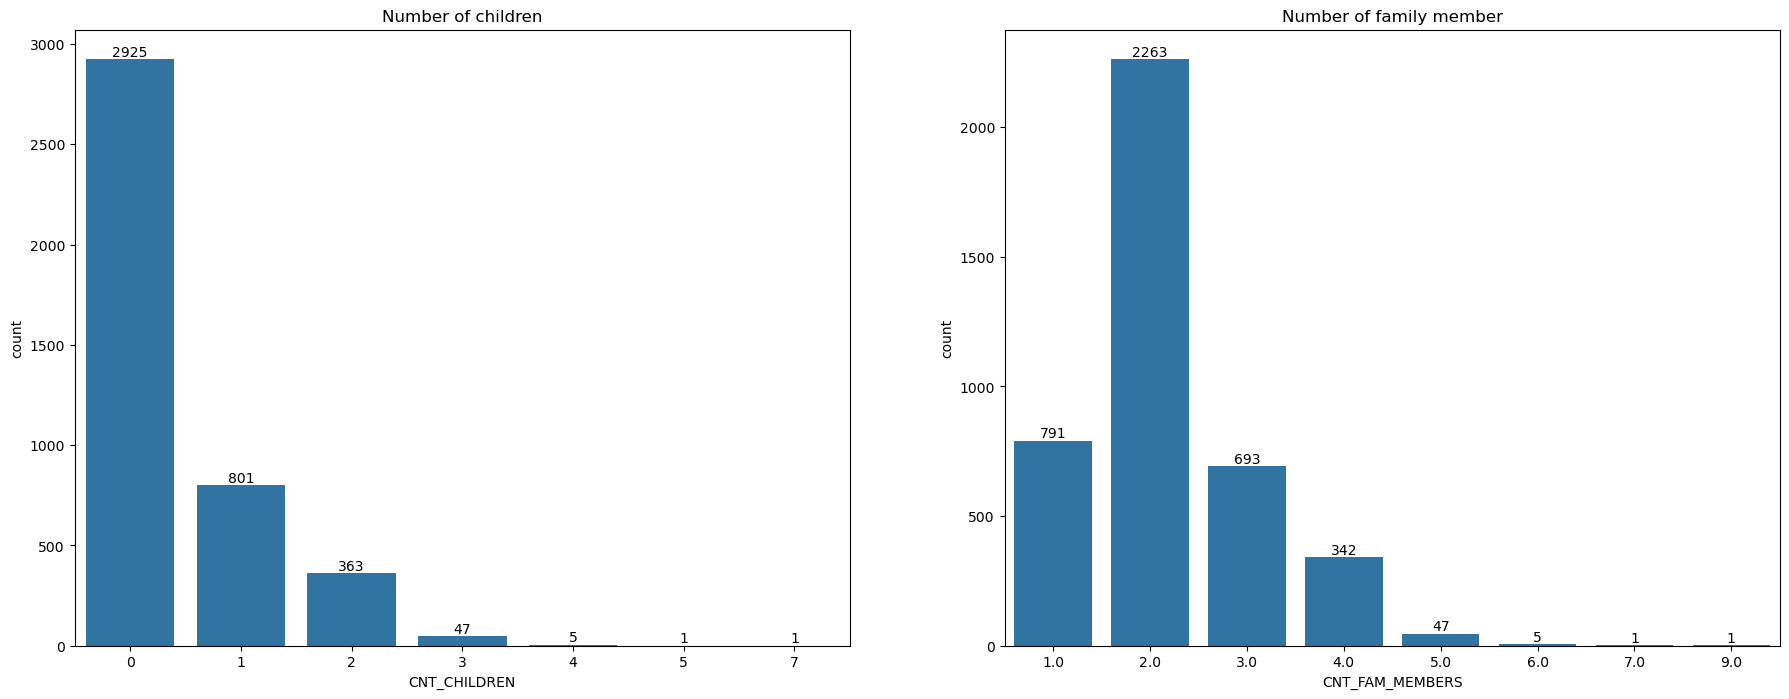

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))
cplot = sns.countplot(data=df_labeled, x="CNT_CHILDREN", ax=ax[0],color='tab:Blue')
for container in cplot.containers:
    cplot.bar_label(container)
ax[0].set_title('Number of children')

cplot = sns.countplot(data=df_labeled, x="CNT_FAM_MEMBERS", ax=ax[1],color='tab:Blue')
for container in cplot.containers:
    cplot.bar_label(container)
ax[1].set_title('Number of family member')

There is clearly outliers on both number of children and family member. The distribution of number of family greater than 1 is exactly the same as the distribution of number of children. This shows that these two features are highly correlated.

Text(0.5, 1.0, 'Plot of number of family member and number of children')

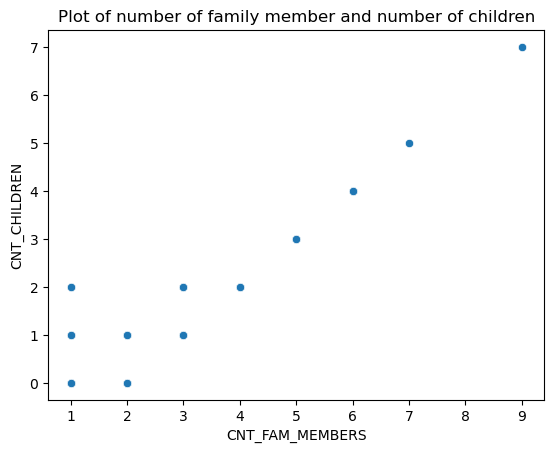

In [ ]:
sns.scatterplot(data=df_labeled, x="CNT_FAM_MEMBERS",y="CNT_CHILDREN")
plt.title('Plot of number of family member and number of children')

In [ ]:
df_labeled[["CNT_CHILDREN","CNT_FAM_MEMBERS"]].corr()

,CNT_CHILDREN,CNT_FAM_MEMBERS
CNT_CHILDREN,1.000000,0.882908
CNT_FAM_MEMBERS,0.882908,1.000000


The plot of number of family member and number of children and correlation table confirm the correlation. As the number of family member cover the number of children, we chose to drop the number of children feature.

In [ ]:
df_labeled = df_labeled.drop("CNT_CHILDREN",axis=1)

In [ ]:
df_labeled["CNT_FAM_MEMBERS"].value_counts(normalize=True)*100

2.0    54.622254
1.0    19.092445
3.0    16.727009
4.0     8.254888
5.0     1.134444
6.0     0.120685
9.0     0.024137
7.0     0.024137
Name: CNT_FAM_MEMBERS, dtype: float64

In [ ]:
[WOE, IV] = WOE_cal(df_labeled,"CNT_FAM_MEMBERS")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): inf


,Dist_bad,Dist_good,WOE
CNT_FAM_MEMBERS,,,
5.0,0.022472,0.011100,-0.705308
1.0,0.269663,0.189196,-0.354390
3.0,0.168539,0.167242,-0.007726
2.0,0.494382,0.547361,0.101799
4.0,0.044944,0.083374,0.617929
6.0,0.000000,0.001233,inf
7.0,0.000000,0.000247,inf
9.0,0.000000,0.000247,inf


As the logit and CNT_FAM_MEMBERS is not linear (We tested it, but not showing here). We categorize this into categorical data instead. We grouped customer who has 5 or more family together. For 1-4 family member, we group them separately according to the amount of family member.

In [ ]:
def gen_bin_fam(df):
    # return group assigned for bin size = binSize
    # assign data > binOver to the last group
    binSize = 1
    binOver = 5
    if df < binOver:
        return str(math.ceil(df/binSize))
    else:
        return str(math.ceil(binOver/binSize))

In [ ]:
df_labeled["FAM_GROUP"] = df_labeled["CNT_FAM_MEMBERS"].apply(gen_bin_fam)
df_labeled["FAM_GROUP"] = df_labeled["FAM_GROUP"].astype('object')

In [ ]:
df_labeled= df_labeled.drop("CNT_FAM_MEMBERS",axis=1)

Text(0.5, 1.0, 'Percentage of Bad Customer in each group')

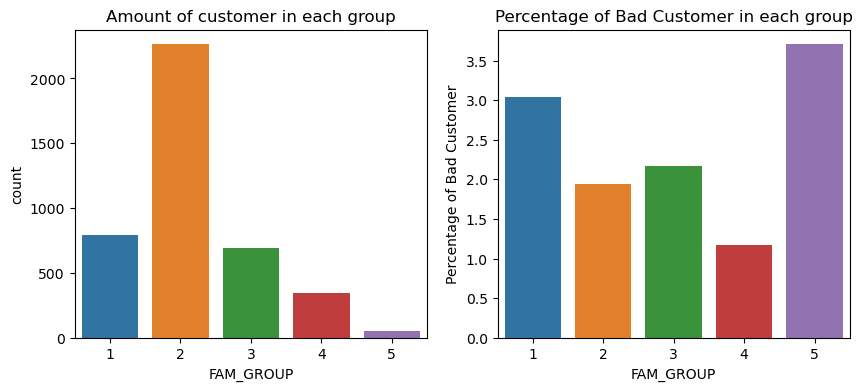

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))
RowPlot = "FAM_GROUP"
sns.countplot(data=df_labeled, x=RowPlot,ax=ax[0],order=['1','2','3','4','5'])
ax[0].set_title("Amount of customer in each group")

df_fam_percent_bad = df_labeled[[RowPlot,"Bad_Customer"]].groupby(RowPlot,as_index=False).mean()
df_fam_percent_bad["Bad_Customer"] = df_fam_percent_bad["Bad_Customer"]*100
sns.barplot(data=df_fam_percent_bad, x=RowPlot, y="Bad_Customer", ax=ax[1])
plt.ylabel("Percentage of Bad Customer")
ax[1].set_title("Percentage of Bad Customer in each group")

In [ ]:
[WOE, IV] = WOE_cal(df_labeled,"FAM_GROUP")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.06307555859223359


,Dist_bad,Dist_good,WOE
FAM_GROUP,,,
5,0.022472,0.012827,-0.560726
1,0.269663,0.189196,-0.354390
3,0.168539,0.167242,-0.007726
2,0.494382,0.547361,0.101799
4,0.044944,0.083374,0.617929


</br>





### AGE

<Axes: xlabel='AGE', ylabel='Count'>

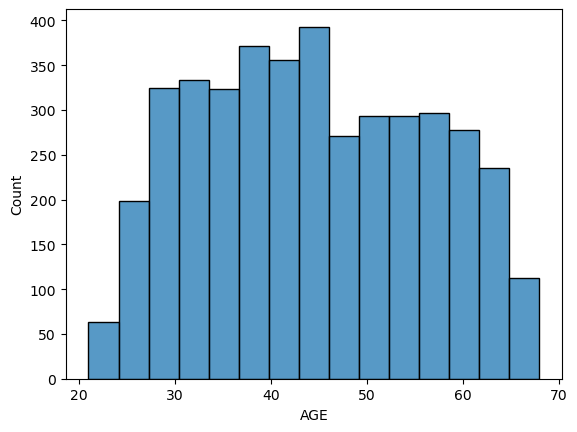

In [ ]:
sns.histplot(data=df_labeled, x="AGE",bins=15)

As the logit and AGE is not linear (We tested it, but not showing here). We categorize this into categorical data instead. We grouped customer younger than 25 years old together, and older than 65 years old together. For the customer whose age between 25 and 65 we group them with 5 year-old bin spacing.

In [ ]:
def gen_bin_age(df):
    # return group assigned for bin size = binSize
    # assign data > binOver to the last group
    binSize = 5
    binOver = 65
    binMin = 25
    if df <= binMin:
        return str(1)
    elif df <= binOver:
        return str(math.ceil((df-binMin)/binSize))
    else:
        return str(math.ceil((binOver-binMin)/binSize))

In [ ]:
df_labeled["AGE_GROUP"] = df_labeled["AGE"].apply(gen_bin_age)
df_labeled["AGE_GROUP"] = df_labeled["AGE_GROUP"].astype('object')

In [ ]:
df_labeled= df_labeled.drop("AGE",axis=1)

Text(0.5, 1.0, 'Percentage of Bad Customer in each group')

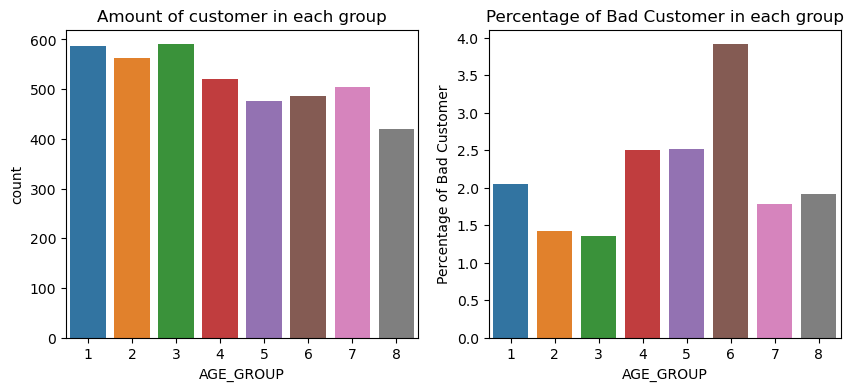

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))
RowPlot = "AGE_GROUP"
sns.countplot(data=df_labeled, x=RowPlot,ax=ax[0],order=map(str,range(1,9)))
ax[0].set_title("Amount of customer in each group")

df_fam_percent_bad = df_labeled[[RowPlot,"Bad_Customer"]].groupby(RowPlot,as_index=False).mean()
df_fam_percent_bad["Bad_Customer"] = df_fam_percent_bad["Bad_Customer"]*100
sns.barplot(data=df_fam_percent_bad, x=RowPlot, y="Bad_Customer", ax=ax[1],order=map(str,range(1,9)))
plt.ylabel("Percentage of Bad Customer")
ax[1].set_title("Percentage of Bad Customer in each group")

From the graph, customer age between 50-55 (group 6) has high percentage of  bad customer.

In [ ]:
[WOE, IV] = WOE_cal(df_labeled,"AGE_GROUP")
print("Information value (IV):", IV)
WOE

Information value (IV): 0.11762678798419732


,Dist_bad,Dist_good,WOE
AGE_GROUP,,,
1,0.134831,0.141589,0.048900
2,0.089888,0.136655,0.418900
3,0.089888,0.143562,0.468206
4,0.146067,0.125062,-0.155261
5,0.134831,0.114455,-0.163845
6,0.213483,0.115195,-0.616933
7,0.101124,0.122102,0.188510
8,0.089888,0.101381,0.120329


</br>





### AMT_INCOME_TOTAL

<Axes: xlabel='AMT_INCOME_TOTAL', ylabel='Count'>

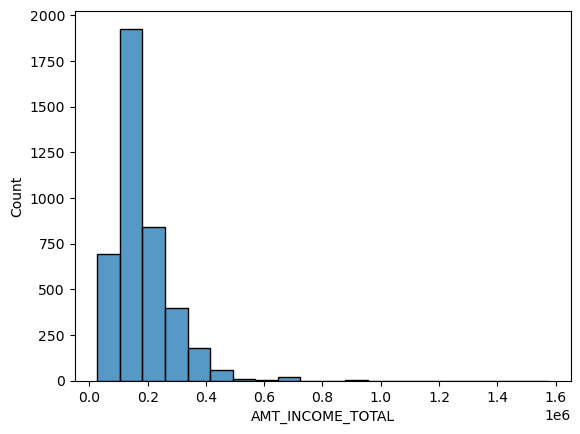

In [ ]:
sns.histplot(data=df_labeled, x="AMT_INCOME_TOTAL",bins=20)

As the logit and AMT_INCOME_TOTAL is not linear (We tested it, but not showing here). We categorize this into categorical data instead. We grouped customer having income less than 80000 together, and greater than 320000 together. For the customer haveing income between 40000 and 320000 we group them with 40000 d bin spacing.

In [ ]:
def gen_bin_income(df):
    # return group assigned for bin size = binSize
    # assign data > binOver to the last group
    binSize =40000
    binOver = 320000
    binMin = 80000
    if df <= binMin:
        return str(1)
    elif df <= binOver:
        return str(math.ceil((df-binMin)/binSize))
    else:
        return str(math.ceil((binOver-binMin)/binSize))

In [ ]:
df_labeled["AMT_INCOME_TOTAL_GROUP"] = df_labeled["AMT_INCOME_TOTAL"].apply(gen_bin_income)
df_labeled["AMT_INCOME_TOTAL_GROUP"] = df_labeled["AMT_INCOME_TOTAL_GROUP"].astype('object')
df_labeled= df_labeled.drop("AMT_INCOME_TOTAL",axis=1)

Text(0.5, 1.0, 'Percentage of Bad Customer in each group')

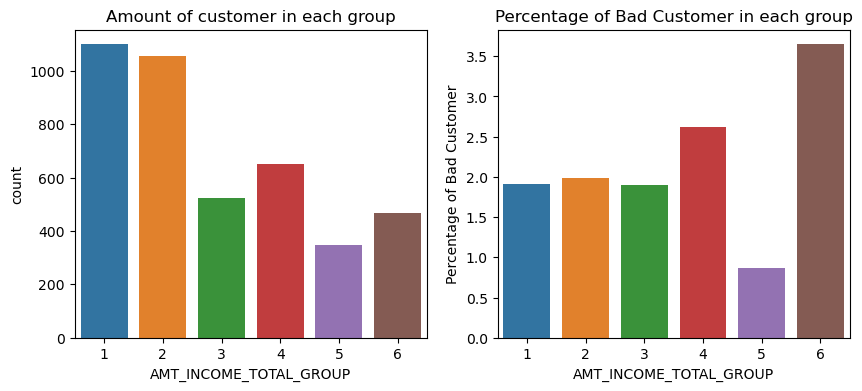

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))
RowPlot = "AMT_INCOME_TOTAL_GROUP"
sns.countplot(data=df_labeled, x=RowPlot,ax=ax[0],order=['1','2','3','4','5','6'])
ax[0].set_title("Amount of customer in each group")

df_fam_percent_bad = df_labeled[[RowPlot,"Bad_Customer"]].groupby(RowPlot,as_index=False).mean()
df_fam_percent_bad["Bad_Customer"] = df_fam_percent_bad["Bad_Customer"]*100
sns.barplot(data=df_fam_percent_bad, x=RowPlot, y="Bad_Customer", ax=ax[1])
plt.ylabel("Percentage of Bad Customer")
ax[1].set_title("Percentage of Bad Customer in each group")

Surprisingly, the group that has highest precentage of bad customer is group 6 or the customer who has income over 320000

In [ ]:
[WOE, IV] = WOE_cal(df_labeled,"AMT_INCOME_TOTAL_GROUP")
print("Information value (IV):", IV)
WOE

Information value (IV): 0.10537685224854373


,Dist_bad,Dist_good,WOE
AMT_INCOME_TOTAL_GROUP,,,
1,0.235955,0.265910,0.119517
2,0.235955,0.255303,0.078811
3,0.112360,0.127035,0.122759
4,0.191011,0.155895,-0.203147
5,0.033708,0.085101,0.926109
6,0.191011,0.110755,-0.545013


</br>





### YEAR_EMPLOYED

For year employed, we could not continue with continuous data as year employed for pensioner is undefined. Hence we group year employed to be a categorical data.

<Axes: xlabel='count', ylabel='YEAR_EMPLOYED'>

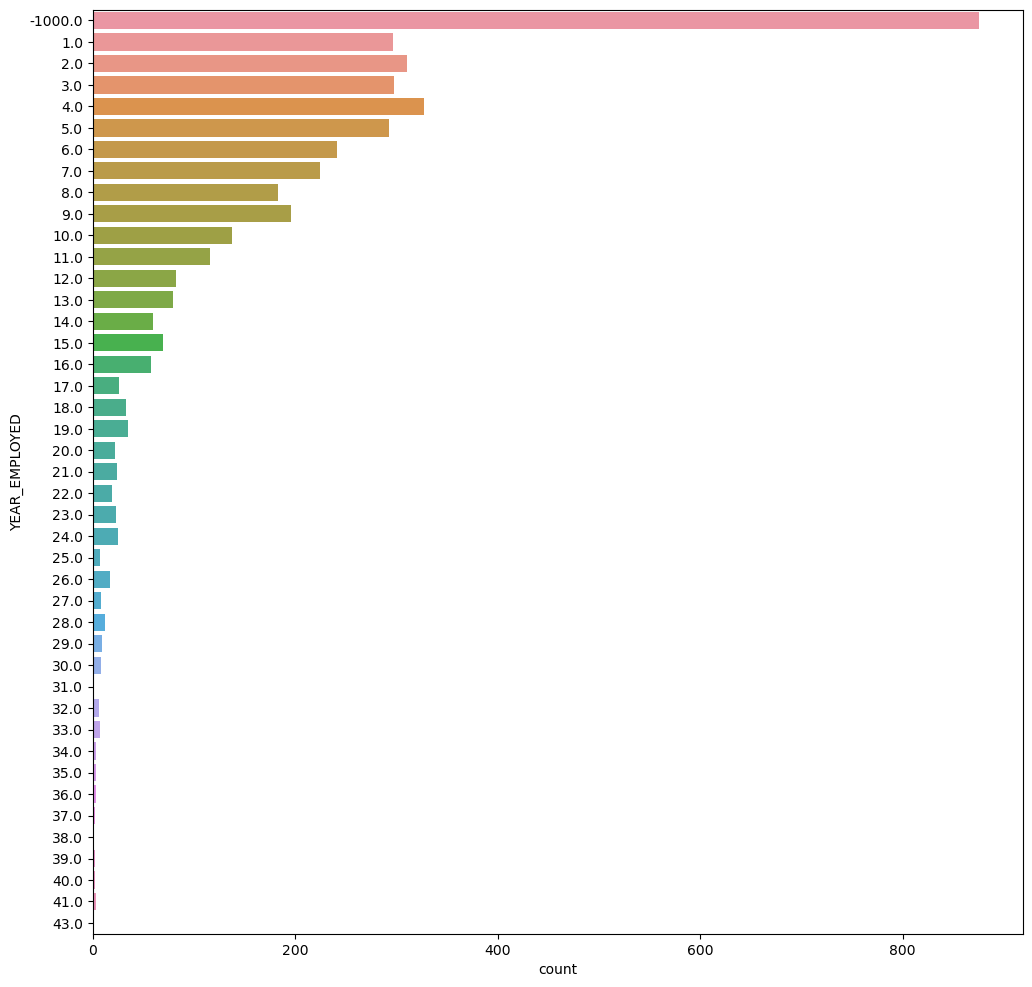

In [ ]:
# Show distribution of the data
fig, ax = plt.subplots(figsize=(12, 12))
sns.countplot(data=df_labeled,y="YEAR_EMPLOYED")

<Axes: xlabel='Bad_Customer', ylabel='YEAR_EMPLOYED'>

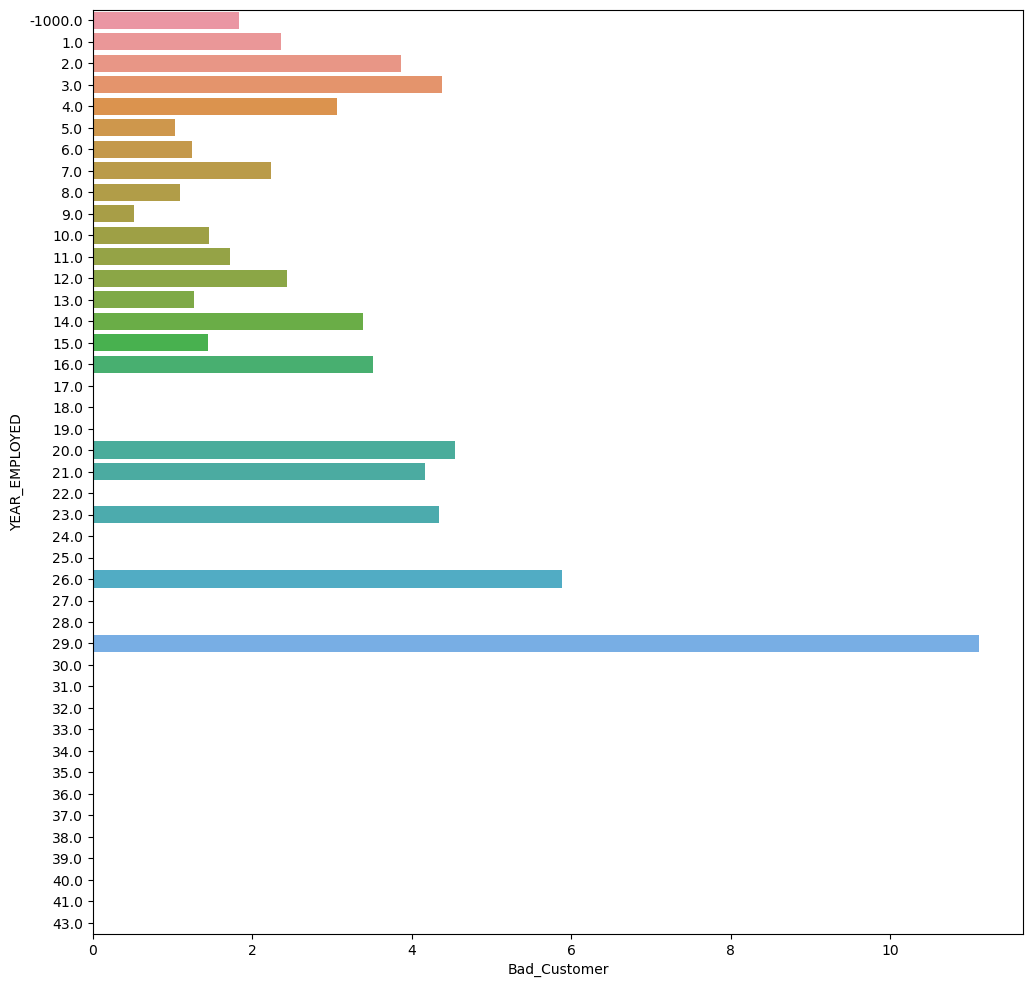

In [ ]:
# Percentage of bad customer for each year employed`
fig, ax = plt.subplots(figsize=(12, 12))
df_year_percent_bad = df_labeled[["YEAR_EMPLOYED","Bad_Customer"]].groupby("YEAR_EMPLOYED",as_index=False).mean()
df_year_percent_bad["Bad_Customer"] = df_year_percent_bad["Bad_Customer"]*100
sns.barplot(data=df_year_percent_bad, y="YEAR_EMPLOYED", x="Bad_Customer",orient='h')

We categorize this into categorical data instead. For pensioner  we separatly grouped them together. We grouped customer have been working greater than 16 years together. For the customers have been working between 2 and 16 we group them with 2 year bin spacing.

In [ ]:
def gen_bin_year(df):
    # return group assigned for bin size = binSize
    # assign data > binOver to the last group
    binSize = 2
    binOver = 16
    if df == -1000:
        return str(1)
    elif df <= binOver:
        return str(math.ceil(df/binSize) + 1)
    else:
        return str(math.ceil(binOver/binSize) + 1)

In [ ]:
df_labeled["YEAR_EMPLOYED_GROUP"] = df_labeled["YEAR_EMPLOYED"].apply(gen_bin_year)

Text(0.5, 1.0, 'Percentage of Bad Customer in each group')

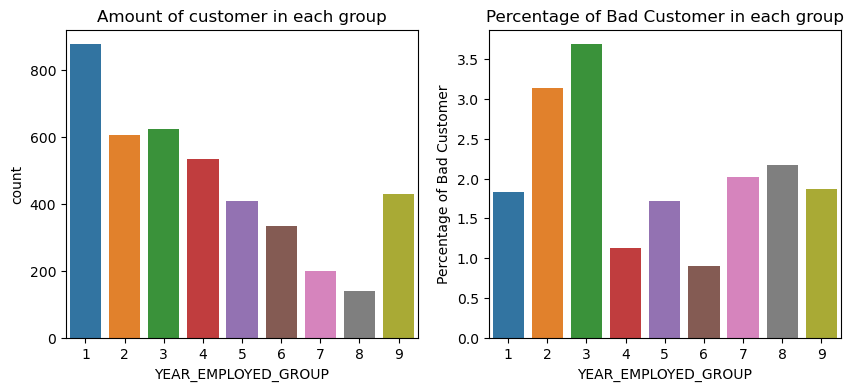

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))
RowPlot = "YEAR_EMPLOYED_GROUP"
sns.countplot(data=df_labeled, x=RowPlot,ax=ax[0],order=map(str,range(1,10)))
ax[0].set_title("Amount of customer in each group")

df_fam_percent_bad = df_labeled[[RowPlot,"Bad_Customer"]].groupby(RowPlot,as_index=False).mean()
df_fam_percent_bad["Bad_Customer"] = df_fam_percent_bad["Bad_Customer"]*100
sns.barplot(data=df_fam_percent_bad, x=RowPlot, y="Bad_Customer", ax=ax[1])
plt.ylabel("Percentage of Bad Customer")
ax[1].set_title("Percentage of Bad Customer in each group")

It is clear that customer who have been working between 3-5 years (group 2 and 3) have the highest percentage of bad customers.

In [ ]:
[WOE, IV] = WOE_cal(df_labeled,"YEAR_EMPLOYED_GROUP")
print("Information value (IV):", IV)
WOE

Information value (IV): 0.18326788992276247


,Dist_bad,Dist_good,WOE
YEAR_EMPLOYED_GROUP,,,
1,0.179775,0.211889,0.164357
2,0.213483,0.144795,-0.388237
3,0.258427,0.148249,-0.555722
4,0.067416,0.130242,0.658514
5,0.078652,0.098668,0.226731
6,0.033708,0.081401,0.881657
7,0.044944,0.047854,0.062741
8,0.033708,0.033300,-0.012160
9,0.089888,0.103601,0.141990


In [ ]:
df_labeled= df_labeled.drop("YEAR_EMPLOYED",axis=1)
df_labeled["YEAR_EMPLOYED_GROUP"] = df_labeled["YEAR_EMPLOYED_GROUP"].astype('object')

</br>


## Modeling ===========

In [ ]:
df_labeled.head()

,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,OCCUPATION_TYPE,Bad_Customer,FAM_GROUP,AGE_GROUP,AMT_INCOME_TOTAL_GROUP,YEAR_EMPLOYED_GROUP
0,Working,Civil marriage,G5,0,2,3,1,8
1,Pensioner,Married,G4,0,2,6,1,1
2,Working,Married,G5,0,2,3,1,2
3,Pensioner,Married,G4,0,2,8,1,1
4,Pensioner,Single / not married,G4,0,1,7,1,1


In [ ]:
df_labeled["Bad_Customer"].value_counts(normalize=True)*100

0    97.851798
1     2.148202
Name: Bad_Customer, dtype: float64

#### Split data into train and test set.

#### Handle imbalance data by using SMOTE.

#### Encode data

In [ ]:
df_LogReg_one = df_labeled
x_LogReg = df_LogReg_one.drop("Bad_Customer",axis=1)
y_LogReg = df_LogReg_one["Bad_Customer"]
x_LogReg_train, x_LogReg_test, y_LogReg_train, y_LogReg_test = train_test_split(x_LogReg, y_LogReg, test_size=0.25, stratify=y_LogReg, random_state=42)

In [ ]:
x_LogReg_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3107 entries, 2861 to 1167
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   NAME_INCOME_TYPE        3107 non-null   object
 1   NAME_FAMILY_STATUS      3107 non-null   object
 2   OCCUPATION_TYPE         3107 non-null   object
 3   FAM_GROUP               3107 non-null   object
 4   AGE_GROUP               3107 non-null   object
 5   AMT_INCOME_TOTAL_GROUP  3107 non-null   object
 6   YEAR_EMPLOYED_GROUP     3107 non-null   object
dtypes: object(7)
memory usage: 194.2+ KB


In [ ]:
x_train_balance,y_train_balance = SMOTEN(random_state=10).fit_resample(x_LogReg_train,y_LogReg_train)
x_LogReg_train_encoded = pd.get_dummies(x_train_balance)
x_LogReg_test_encoded = pd.get_dummies(x_LogReg_test)

In [ ]:
x_LogReg_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6080 entries, 0 to 6079
Data columns (total 44 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   NAME_INCOME_TYPE_Commercial associate    6080 non-null   uint8
 1   NAME_INCOME_TYPE_Pensioner               6080 non-null   uint8
 2   NAME_INCOME_TYPE_State servant           6080 non-null   uint8
 3   NAME_INCOME_TYPE_Working                 6080 non-null   uint8
 4   NAME_FAMILY_STATUS_Civil marriage        6080 non-null   uint8
 5   NAME_FAMILY_STATUS_Married               6080 non-null   uint8
 6   NAME_FAMILY_STATUS_Separated/Widow       6080 non-null   uint8
 7   NAME_FAMILY_STATUS_Single / not married  6080 non-null   uint8
 8   OCCUPATION_TYPE_G1                       6080 non-null   uint8
 9   OCCUPATION_TYPE_G2                       6080 non-null   uint8
 10  OCCUPATION_TYPE_G3                       6080 non-null   uint8
 11  OCCU

## Binary Logistic regression


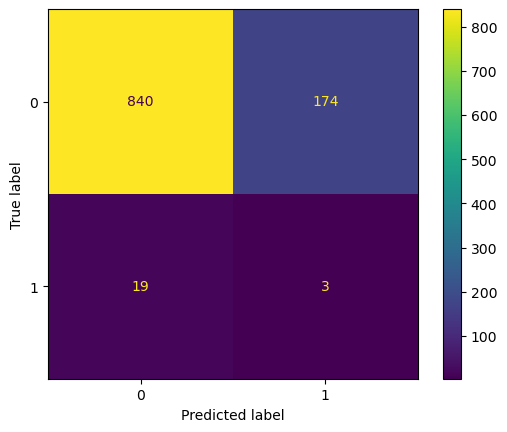

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      1014
           1       0.02      0.14      0.03        22

    accuracy                           0.81      1036
   macro avg       0.50      0.48      0.46      1036
weighted avg       0.96      0.81      0.88      1036



In [ ]:
log_clf = LogisticRegression(random_state=42, max_iter=2000).fit(x_LogReg_train_encoded, y_train_balance)
y_predict= log_clf.predict(x_LogReg_test_encoded)
log_cm = confusion_matrix(y_LogReg_test, y_predict, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm,
                                  display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()
print(classification_report(y_LogReg_test,y_predict))
y_pred_log = y_predict.copy()


## Random Forest

In [ ]:
cv_params = {'n_estimators' : [50,100,200],
              'max_depth' : [10,20,50],
              'min_samples_leaf':[1,5,10]}
rf = RandomForestClassifier(random_state=0)
rf_val = GridSearchCV(rf, cv_params, refit='f1')
rf_val.fit(x_LogReg_train_encoded, y_train_balance)

GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [10, 20, 50],
                         'min_samples_leaf': [1, 5, 10],
                         'n_estimators': [50, 100, 200]},
             refit='f1')

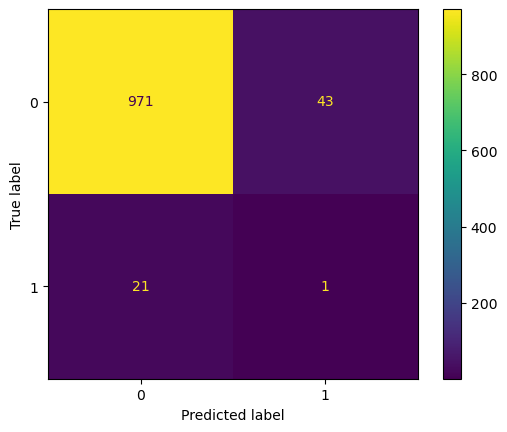

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1014
           1       0.02      0.05      0.03        22

    accuracy                           0.94      1036
   macro avg       0.50      0.50      0.50      1036
weighted avg       0.96      0.94      0.95      1036



In [ ]:
y_predict = rf_val.predict(x_LogReg_test_encoded)
log_cm = confusion_matrix(y_LogReg_test, y_predict, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm,
                                  display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()
print(classification_report(y_LogReg_test,y_predict))
y_pred_rf = y_predict.copy()

# XGBOOST

In [ ]:
cv_params = {'max_depth': [4, 6, 8],
              'min_child_weight': [1, 3, 5],
              'learning_rate': [0.1, 0.3, 0.5],
              'n_estimators': [50,100,200],
              }
scoring = {'accuracy', 'precision', 'recall', 'f1'}

In [ ]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0)
xgb_cv = GridSearchCV(xgb,
                      cv_params,
                      scoring = scoring,
                      cv = 5,
                      refit = 'f1'
                     )

In [ ]:
xgb_cv = xgb_cv.fit(x_LogReg_train_encoded, y_train_balance)
xgb_cv

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1, 0.3, 0.5],
                         'max_depth': [4, 6, 8], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [50, 100, 200]},
             refit='f1', scoring={'precision', 'recall', 'accuracy', 'f1'})

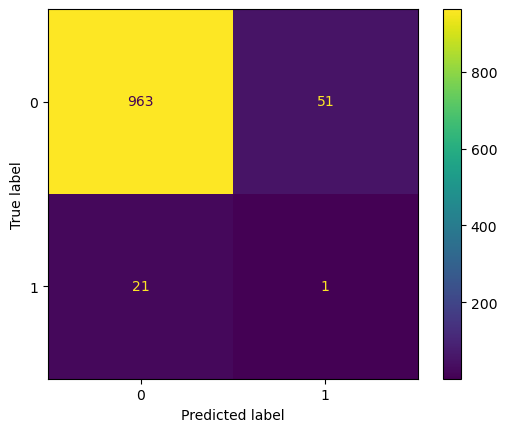

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1014
           1       0.02      0.05      0.03        22

    accuracy                           0.93      1036
   macro avg       0.50      0.50      0.50      1036
weighted avg       0.96      0.93      0.94      1036



In [ ]:
y_predict = xgb_cv.predict(x_LogReg_test_encoded)
log_cm = confusion_matrix(y_LogReg_test, y_predict, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm,
                                  display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()
print(classification_report(y_LogReg_test,y_predict))
y_pred_xg = y_predict.copy()

## Conclusion ===========

The models developed failed to predict bad customers. Though the process can be finely tuned, e.g. choices of grouping data, and feature engineering (which we already did some experiment (not shown here)), the performance of the model is not increase significantlty. The assumption we made are 1) The lack of highly relavant data, e.g. debt, mortgage, and expense. 2) There is small example of bad customer (the data is highly imbalance).